<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [3.4 Implementing Controllers in Python](https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.html) | [Contents](toc.html) | [3.6 Lab Assignment 3: Relay and PI Control](https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PI-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.5 Proportional (P) and Proportional-Integral (PI) Control

## 3.5.1 Learning Goals

* Be able be write expressions for proportional control, and proportional-integral control in position and velocity forms.
* Define terminology
    * negative feedback
    * bias (or offset, or null) term
    * proportional gain and integral gain
    *
* Explain how the proportional and integral terms contribute to acheving feedback control to a setpoint.
* Explain the purpose of each of the following enhancements of 'textbook' PI control:
    * Anti-reset windup
         * Control algorithm modifications
         * Event loop modifications
    * Bumpless Transfer
    

## 3.5.2 Proportional Control

### 3.5.2.1 Descripton

Unlike on-off relay control, **proportional control** continuously adjusts the manipulated variable in proportion to the error between the setpoint and measured process variable.

\begin{align}
MV_k & = \bar{MV} + K_P(SP_k  - PV_k)
\end{align}

$K_p$ is a constant of proportionality called the **proportional control gain**. The **error signal** is the difference between the the measured process variable and setpoint,

\begin{align}
e_k & = PV_k - SP_k
\end{align}

for which the proportional control becomes

\begin{align}
MV_k & = \bar{MV} - K_P e_k
\end{align}

The negative sign is why this is called **negative feedback control**. Negative feedback suppresses deviations from the setpoint. Assuming the proportional gain is positive, and that the process being controlled exhibits a positive causal relationship between the manipulated variable and process variable, if the process variable grows above the setpoint, then the manipulated variable is decreased. If the process variable falls below the setpoint, then the manipulated variable is increased.

The constant term $\bar{MV}$ is called the **bias**, **offset**, or **null** value of the manipulated variable. It is an initial estimate of the value of the manipulated variable required to maintain the desired setpoint. The estimate can be determined in several ways including:

* manual adjustment of the manipulated variable followed by a transition to automatic control,
* solving a process model for the desired steady state,
* feedforward control,
* a user provided estimate,
* ignored.

In subsequent notebooks we will see how $\bar{MV}$ is used when building advanced control implementations.

### 3.5.2.2 Implementation

Our first implementation of feedback control will use a Python generator. An instance of a proportional controller is created by specifying the gain $K_P$, upper and lower bounds on the manipulated variable, and the offset value $\bar{MV}$.

In [ ]:
def P(Kp, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV = MV_bar - Kp*e

# create a controller instance with default parameter values
controller = P(3.0)

### 3.5.2.3 Controller Testing

Let's see how the proportional control works when applied to the Temperature Control Laboratory. For this simulation we set $\bar{MV} = 0$ and $K_p = 3.0$.

The following cell creates a function `experiment` that we can use to test controllers. The experiment tests the ability of the control to maintain a setpoint point for temperature T1, and to suppress the influence of a disturbance due to switching on the second heater.

In [ ]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_final=450, t_step=2,
               SP=lambda t: 40 if t >= 20 else 0, 
               D=lambda t: 100 if t >= 220 else 0):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = controller.send((SP(t), T1))
            lab.Q1(U1)
            lab.Q2(D(t))
            p.update(t)    
            
controller = P(3.0)
experiment(controller)

For systems without significant time delay and with properly chosen parameters, proportional control can achieve a fast response to changes in setpoint. Note, however, the steady state may be different than the desired setpoint, sometimes unacceptably different. This steady-state error a short-coming of purely proportional control.

<hr>

**Study Question:** Test the simulation for values of $K_p$ that are twice as large, and half as large as demonstrated above. What do you notice about the steady-state error between the desired setpoint and the measured process variable?

<hr>

### 3.5.2.4 Empirical Tuning Rules

There are a number of **tuning rules** in the literature that provide recommended values for the proportional gain $K_P$. These rules typically require process information obtained from testing. 

Given process gain $K$, process time constant $\tau$, and process time delay $\tau_{delay}$, one example of recommended values are (from Seborg, Edgar, Mellichamp, Doyle):

\begin{align}
\text{Setpoint Tracking}\qquad & K_P = \frac{0.202}{K} \left(\frac{\tau_{delay}}{\tau}\right)^{-1.219} \\
\\
\text{Disturbance Rejection}\qquad  & K_P = \frac{0.490}{K} \left(\frac{\tau_{delay}}{\tau}\right)^{-1.084}
\end{align}

In [ ]:
K_process = 0.6
t_process = 140
t_delay = 20

Kp_setpoint = (0.202/K_process) * (t_delay/t_process)**-1.219
print(Kp_setpoint)

controller = P(Kp_setpoint)
experiment(controller)

<hr>

**Study Question:** Repeat the above experiment using the recommended proportional control gain for disturbance rejection. How does the response to 

<hr>

### 3.5.2.5 Steady-State Offset

Proportional-only control provides no assurance the the process variable will eventually acquire the setpoint. To see this, consider the proportional control law

$$MV_k = \bar{MV} - K_P e_k$$

in the limit $k\rightarrow\infty$. 

$$e_{\infty} = \frac{\bar{MV} - M_{\infty}}{K_P}$$

The error $e_\infty$ expresses the steady-state difference between a process variable and it setpoint. With proportional control, the only options to reduce steady-state offset are 

1. Increase $K_P$. This leads to increasing oscillations and relay-like behavior of the manipulated variable.
2. Find a perfect initial estimate for $\bar{MV}$. If we could do this, we wouldn't need feedback control.

A persistent steady-state offset is most significant shortcoming of proportional-only control.

## 3.5.3 Proportional-Integral (PI) Control

### 3.5.3.1 Position form

Given a process variable $PV$ and setpoint $SP$, proportional-integral control is defined by the relation

\begin{align}
MV(t) & = \bar{MV} + K_P(SP(t) - PV(t)) + K_I\int_{-\infty}^t (SP(t') - PV(t'))\,dt'
\end{align}

where **$K_P$ is the proportional gain** and **$K_I$ is the integral gain**. When implemented in discrete time with time steps of length $h$, the basic rule for proportional-integral control becomes

\begin{align}
MV_k & = \bar{MV} + K_P(SP_k  - PV_k) + h K_I\sum_{j=0}^{j=k}(SP_j -  PV_j)
\end{align}

This is the so-called **position form** of PI control. This formula specifies the value (or "position") of the manipulated variable stricly in terms of the current and past values of the **error** signal

\begin{align}
e_k & = PV_k - SP_k
\end{align}

Note the sign convention: A positive error occurs when the process variable is greater than the setpoint. When written in terms of error,

The position form of PI control is rarely used in practice.

### 3.5.3.2 Velocity form

A more common implementation of PI control is done by computing how much the manipulated variable changes at each time step, and incrementing the manipulated variable by that amount.

Defining the error at time $k$ as

\begin{align}
e_k & = PV_k - SP_k
\end{align}

then consecutive values of $MV$ are given by 

\begin{align}
MV_{k-1} & = \bar{MV} - K_p e_{k-1} - h K_i \sum_{j=0}^{k-1} e_{j} \\
MV_{k} & = \bar{MV} - K_p e_{k} - h K_i \sum_{j=0}^{k} e_{j}
\end{align}

Taking differences gives a formula for updating the value of $MV$ in response to process measurements or changes in setpoint.

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

with $MV_0 = \bar{MV}$. Let's see how this works.

In [ ]:
def PI(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV += -Kp*(e - e_prev) - Ki*e
        e_prev = e
        
PI_controller = PI(3, 0.2)
experiment(PI_controller)

As we can see from this example, an important practical property of proportonal-integral control is **steady-state tracking of the setpoint.** In other words, for a steaady setpoint $\bar{SP}$, at steady-state 

\begin{align}
\lim_{k \rightarrow \infty} PV_k = \bar{SP}
\end{align}

To see why this is true, start with the velocity form of the proportional-integral controller

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

At steady-state $MV_{k} = MV_{k-1}$ and $e_{k} = e_{k-1}$ leaving 

$$h K_i e_{k} = 0 \implies e_{k} = 0 \implies PV_{k} = \bar{SP}$$

## 3.5.4 Anti-Reset Windup

### 3.5.4.1 Integral or resent windup

In the next cell we're doing an experiment in which we increase the magnitude of the control gains to see if we an acheive even better control performance. Let's see how we do.

In [ ]:
PI_controller = PI(10, 1.0)
experiment(PI_controller)

<hr>

**Study Question:** Carefully exammine the results of this experiment. The PI velocity algorithm is given by an equation

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

Looking at the period from 0 to 100 seconds, is this equation being satisfied? Why or why not?  

**Study Question:** Carefully examine the code for the PI controller. Is is possible for $MV$ to be different from the actual input applied to the device?

<hr>

### 3.5.4.2 Anti-reset windup - Part 1

There several common strategies for avoiding integral (aka reset) windup. The first of these, which should be part of any practical implementation, is to limit computed values of manipulated variable to the range of allowable values. This will avoid $MV$ 'winding up' due to range limits.

\begin{align}
\hat{MV}_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k} 
\end{align}

\begin{align}
MV_k & = \max(MV^{min}, \min(MV^{max}, \hat{MV}_k)
\end{align}

In [ ]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV += - Kp*(e - e_prev) - Ki*e
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e
        
controller = PI_antiwindup(10, 1.0)
experiment(controller)

### 3.5.4.3 Anti-reset Windup - Part 2

A more subtle form of windup occurs when the manipulated variable is subject to external interventions. This can occur when a valve stem in a process application gets stuck, an operator or user intervenes and resets a mechanical actuator, or there is some sort of system failure. 

For these reasons, practical control systems often include a field measurement of the manipulated variable that is fed back to the controller. The following image, for example, shows a pneumatically operated globe valve with a positioner, and with feedback of position to the central control system.

<p><a href="https://commons.wikimedia.org/wiki/File:Pl_control_valve.jpg#/media/File:Pl_control_valve.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/b/b2/Pl_control_valve.jpg" alt="Pl control valve.jpg" height="720" width="540"></a>
    
 <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>
    
Stepper motors are commonly used actuators in lab equipment and robotics. The position of the stepper motor would be manipulated variable. This is an example of a stepper motor with an integrated encoder that can be used to verify the motor's position.
    
![](https://www.portescap.com/-/media/project/automation-specialty/portescap/portescap/products/workings-of-encoders/encoder_chart_720x450_1_0.jpg)

This behavior also occurs in the Temperature Control Laboratory in which the manipulated power levels are constrained to the range 0% to 100%. This is demonstated in the following cell.

In [16]:
# show that inputs to the TCLab are constrained to the range 0 to 100%

TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    print(f"Q1 = {lab.Q1()}")
    lab.Q1(150)
    print(f"Q1 = {lab.Q1()}")

TCLab version 0.4.9
Simulated TCLab
Q1 = 0
Q1 = 100
TCLab Model disconnected successfully.


To accomodate feedback of the manipulated variable, we first need to modify the event loop to incorporate the measurement of the manipulated variable, then send that value to the controller.

In [ ]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_final=450, t_step=2,
               SP=lambda t: 40 if t >= 20 else 0, 
               D=lambda t: 100 if t >= 220 else 0):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((SP(t), T1, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            lab.Q2(D(t))
            p.update(t)     

The next change is to the controller. The controller now accepts values for PV, SP, and, additionally, MV. To demonstrate the impact of these changes, this example will comment out the software limits placed on MV to show that feedback of manipulated variable is also an anti-reset windwup strategy.

In [ ]:
def PI(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - Ki*e
        # MV = max(MV_min, min(MV_max, MV))
        e_prev = e
        
controller = PI_antiwindup(10, 1.0)
experiment(controller)

## 3.5.5 Bumpless Transfer

1. Set $\bar{MV}$ equal to the current value of the manipulated variable.
2. Set the setpoint equal to the current value of the process variable.



In [ ]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_final=450, t_step=2,
               SP=lambda t: 40 if t >= 20 else 0):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop 
        for t in clock(t_final, t_step):
            if t < 200:
                manual = True
                auto = False
            else:
                manual = False
                if auto is False:
                    controller = PI_antiwindup(3.0, 1.0, MV_bar=lab.Q1)
                    auto = True

            if manual:
                lab.Q1(30)
            else:
                T1 = lab.T1
                U1 = lab.Q1()
                U1 = controller.send((SP(t), T1, U1))
                lab.Q1(U1)
            p.update(t)   
            
controller = PI_antiwindup(10, 1.0)
experiment(controller)

In [ ]:
%matplotlib inline
import numpy as np
from tclab import TCLab, clock, Historian, Plotter, setup

            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((sp(t), T1, U1))    # <==== send U1 to controller 

def experiment2(controller):

    # time horizon and time step
    t_final = 450
    t_step = 2

    # constant setpoint
    def sp(t):
        ti = [0, 0, 220]
        yi = [20, 40, 40]
        return np.interp(t, ti, yi)

    # perform experiment
    TCLab = setup(connected=False, speedup=20)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # main event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((sp(t), T1, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            p.update(t)   

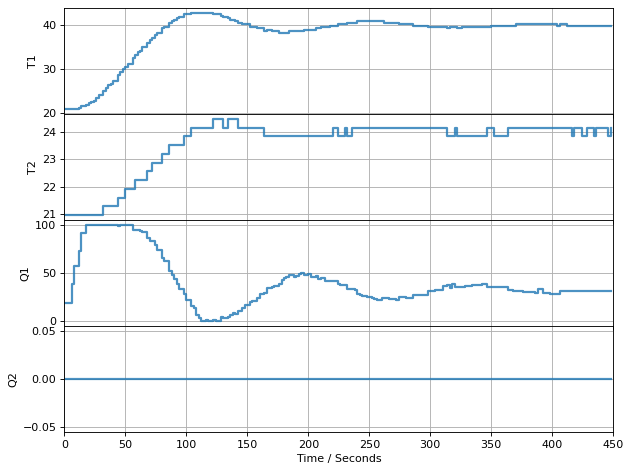

TCLab Model disconnected successfully.


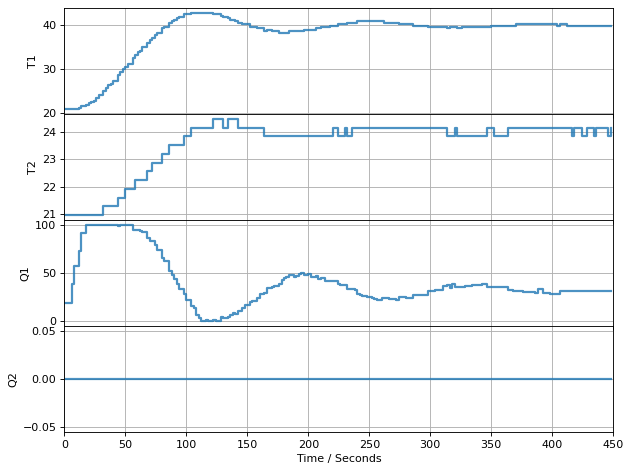

In [46]:
def PI(Kp, Ki, MV_min, MV_max):
    SP, PV, MV = yield MV_min
    MV += -Ki*(PV - SP)
    MV = max(MV_min, min(MV_max, MV))
    PV_prev = PV
    while True:
        SP, PV, MV = yield MV
        MV += -Kp*(PV - PV_prev) - Ki*(PV - SP)
        MV = max(MV_min, min(MV_max, MV))
        PV_prev = PV
        
PI_controller_no_windup = PI(10, 1, MV_min=0, MV_max=100)
experiment2(PI_controller_no_windup)

<!--NAVIGATION-->
< [3.4 Implementing Controllers in Python](https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.html) | [Contents](toc.html) | [3.6 Lab Assignment 3: Relay and PI Control](https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PI-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>